## Fetch the Data and Visualize Data

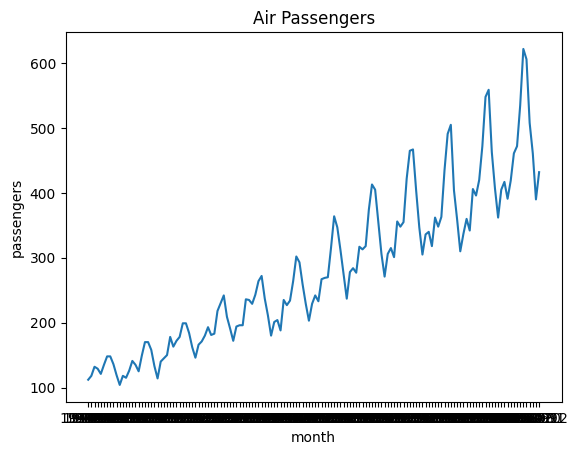

In [126]:
import pandas as pd
import matplotlib.pyplot as plt

# Fetch Data
data = pd.read_csv('data-sets/air_passengers.csv')

month = data['Month']
passengers = data['Passengers']

plt.plot(month, passengers)
plt.xlabel('month')
plt.ylabel('passengers')
plt.title('Air Passengers')
plt.show()

In [127]:
# data = pd.read_csv('data-sets/BTC-USD-5Y.csv')
# date = data['Date']
# close = data['Close']

# plt.plot(date, close)
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.title('Bitcoin Price')
# plt.show()

## Clean trend and seasonality from data

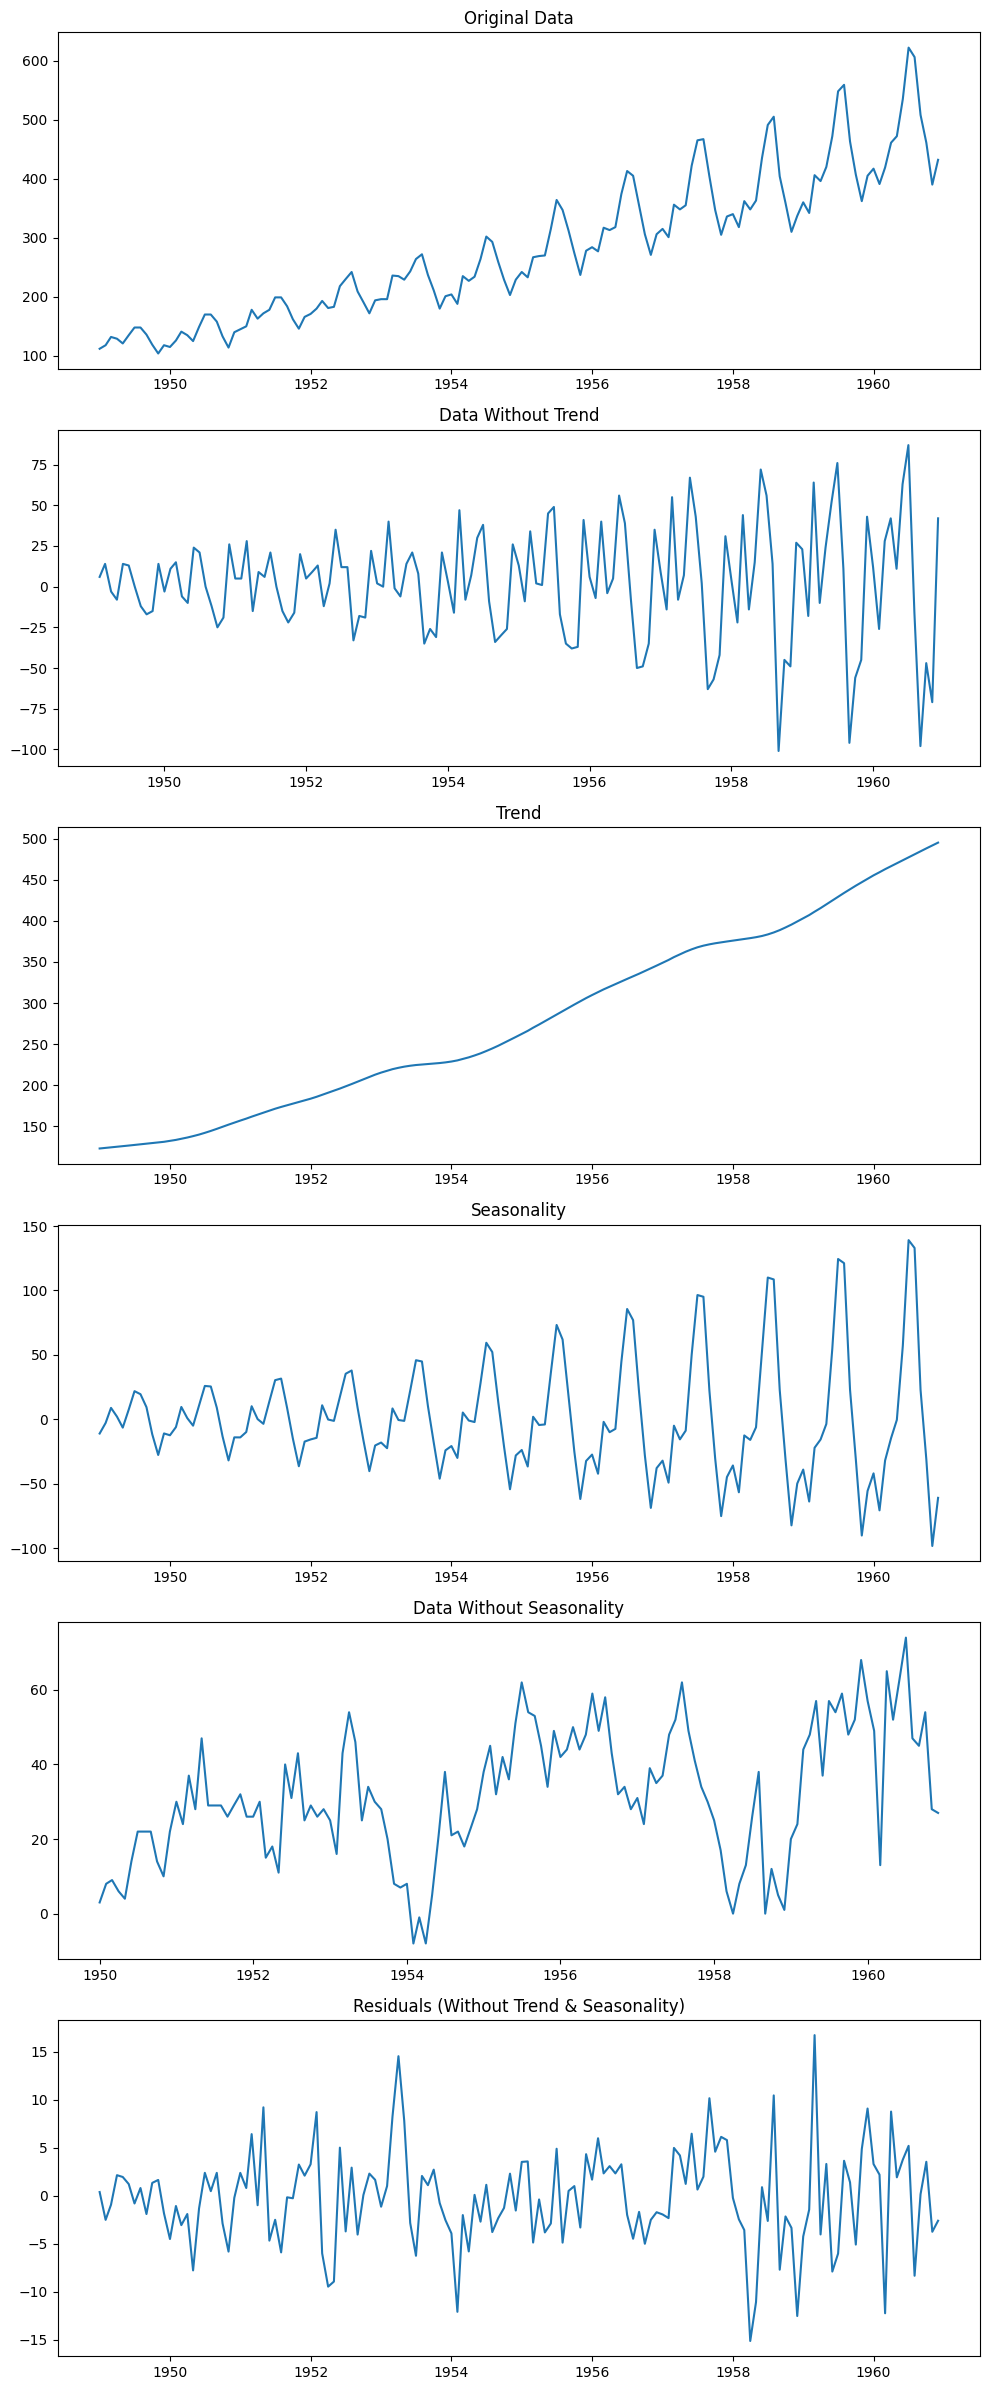

In [128]:
from statsmodels.tsa.seasonal import STL

# Data has a datetime column, set it as the index
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Perform seasonal decomposition
decomp = STL(data['Passengers']).fit()

# Obtain the trend, seasonal, and residual components

# d = 2
data_without_trend = data['Passengers'].diff()
trend = decomp.trend

# seasonality = 12
seasonal_period = 12
data_without_seasonality = data['Passengers'].diff(periods=seasonal_period)
seasonal = decomp.seasonal

residuals = decomp.resid
residuals_df = pd.DataFrame({'residuals': residuals})

# p = 2
residuals_df['t-1'] = residuals_df['residuals'].shift(1).values
residuals_df['t-2'] = residuals_df['residuals'].shift(2).values
residuals_df = residuals_df.dropna()

# Plot the original data, trend, and seasonality
plt.figure(figsize=(10, 24))

plt.subplot(6, 1, 1)
plt.plot(data['Passengers'])
plt.title('Original Data')

plt.subplot(6, 1, 2)
plt.plot(data_without_trend)
plt.title('Data Without Trend')

plt.subplot(6, 1, 3)
plt.plot(trend)
plt.title('Trend')

plt.subplot(6, 1, 4)
plt.plot(seasonal)
plt.title('Seasonality')

plt.subplot(6, 1, 5)
plt.plot(data_without_seasonality)
plt.title('Data Without Seasonality')

plt.subplot(6, 1, 6)
plt.plot(residuals)
plt.title('Residuals (Without Trend & Seasonality)')

plt.tight_layout()
plt.show()

## We will continue with the residuals data

In [129]:
import numpy as np

data = data.reset_index(drop=True)
residuals_df = residuals_df.reset_index(drop=True)

In [130]:
train_size = int(len(residuals_df) * 0.80)
test_size = int(len(residuals_df) * 0.20)


train_data = residuals_df[:train_size]
test_data = residuals_df[train_size:]

In [131]:
from sklearn import linear_model

X_train = train_data[['t-1', 't-2']]
y_train = train_data['residuals']

model = linear_model.LinearRegression()

In [132]:
from sklearn.model_selection import KFold, GridSearchCV
from skopt.plots import plot_objective, plot_histogram
import skopt

# Decleartions for deprecated functions in numpy
np.float = float    
np.int = int    
np.object = object    
np.bool = bool    

# Define hyperparameters for bayesian optimization
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
    }


kFold = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv= kFold, n_jobs=-1, 
                             scoring='neg_mean_absolute_percentage_error')

grid_search.fit(X_train, y_train)

# Print the cross validation results
cv_results = grid_search.cv_results_
cv_results_df = pd.DataFrame(cv_results)

cv_results_df['fit_intercept'] = cv_results_df['params'].apply(lambda x: x['fit_intercept'])
cv_results_df['copy_X'] = cv_results_df['params'].apply(lambda x: x['copy_X'])


print(cv_results_df[['mean_test_score', 'fit_intercept', 'copy_X']])

# plot_objective creates pairwise dependence plot of the objective function.
# plot_objective(bayes_search.optimizer_results_[0],
#                    dimensions=["C", "gamma", "epsilon"],
#                    n_minimum_search=int(1e8))

# Print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

best_model = grid_search.best_estimator_


   mean_test_score  fit_intercept  copy_X
0        -1.739862           True    True
1        -1.656516          False    True
2        -1.739862           True   False
3        -1.656516          False   False
Best hyperparameters: {'copy_X': True, 'fit_intercept': False}


In [133]:
import matplotlib.pyplot as plt

X_test = test_data[['t-1', 't-2']]
y_test = test_data['residuals']


best_model.fit(X_train, y_train)
y_pred_resid = best_model.predict(X_test)


print(y_pred_resid - y_test)

113   -11.214512
114    10.822449
115     0.540265
116     2.032011
117    11.275404
118    -0.036107
119    -0.932098
120   -17.526100
121     9.254980
122    -3.243970
123     8.624201
124     3.763692
125    -6.202664
126    -0.721950
127     5.822599
128    -6.373165
129    -7.939125
130    -0.008859
131    -0.402594
132    13.202687
133   -12.498160
134    -0.108151
135    -2.440984
136    -3.840818
137    10.292907
138    -2.403776
139    -4.159992
140     4.891672
141     1.688174
Name: residuals, dtype: float64


            0
0   11.235429
1   14.362338
2   12.749331
3   11.438435
4   10.196035
5    5.925819
6    3.559741
7    2.758845
8    7.986739
9    8.053792
10   8.785756
11   6.532063
12   3.970602
13   4.646964
14   5.388473
15   3.878168
16   5.020654
17   8.315980
18  10.106801
19  11.075079
20   7.343533
21   9.154327
22  10.477046
23  11.834931
24  13.800640
25  11.560763
26  10.939112
27  12.082934
28  11.171837


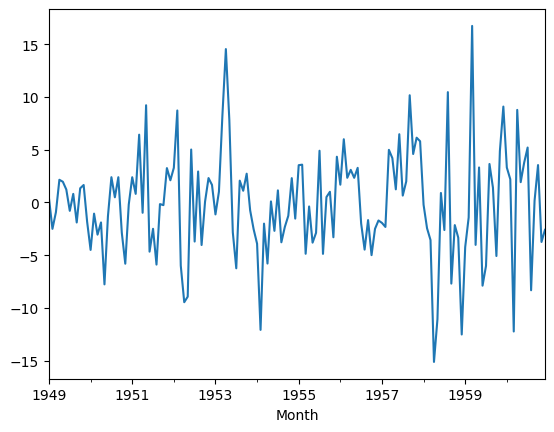

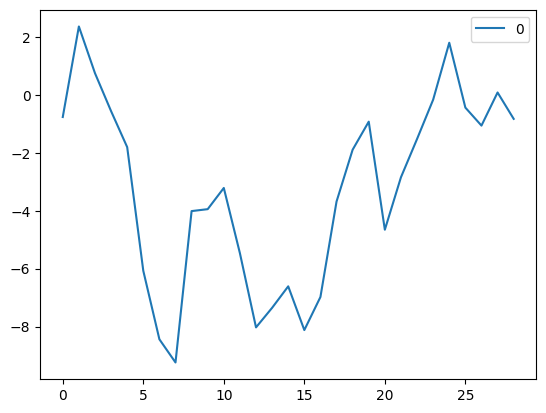

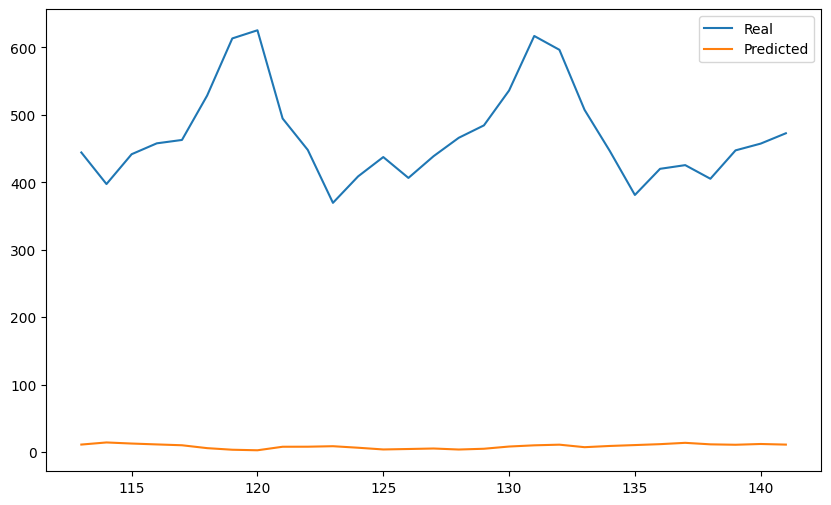

In [134]:
# Our seasonality is yearly (12 months)
seasonal_period = 12 

# Extend the last known value of the trend into the future.
last_known_trend = trend[-seasonal_period:].mean()

# trend_test = np.full(len(X_test), last_known_trend)

# Repeat the last complete seasonal cycle for future periods.
last_seasonal_cycle = seasonal[-seasonal_period:]
seasonal_test = np.tile(last_seasonal_cycle, len(X_test) // seasonal_period + 1)[:len(X_test)]


# Add back the trend and seasonal components.
residuals.plot()

integrated_residue = np.cumsum(y_pred_resid)
integrated_residue = pd.DataFrame(integrated_residue)
integrated_residue.plot()

y_pred = integrated_residue + seasonal_period

print(y_pred)
y_test = y_test + last_known_trend + seasonal_test 

# Plotting
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

In [135]:
from sklearn.metrics import mean_absolute_percentage_error

mse = mean_absolute_percentage_error(y_test, y_pred)
print('Mean Squared Error on test set:', mse)

Mean Squared Error on test set: 0.9806707940275101
